Generating Images with BigGAN
==============================

In [1]:
module_path = 'https://tfhub.dev/deepmind/biggan-deep-512/1'  # 512x512 BigGAN-deep
# module_path = 'https://tfhub.dev/deepmind/biggan-deep-256/1'  # 256x256 BigGAN-deep

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import os
import io
import IPython.display
import numpy as np
import PIL.Image
from scipy.stats import truncnorm
import tensorflow_hub as hub

Instructions for updating:
non-resource variables are not supported in the long term


## Load a BigGAN generator module from TF Hub

In [2]:
tf.reset_default_graph()
print('Loading BigGAN module from:', module_path)
module = hub.Module(module_path)
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().items()}
output = module(inputs)

print()
print('Inputs:\n', '\n'.join(
    '  {}: {}'.format(*kv) for kv in inputs.items()))
print()
print('Output:', output)

Loading BigGAN module from: https://tfhub.dev/deepmind/biggan-deep-256/1
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



Inputs:
   z: Tensor("z:0", shape=(?, 128), dtype=float32)
  y: Tensor("y:0", shape=(?, 1000), dtype=float32)
  truncation: Tensor("truncation:0", shape=(), dtype=float32)

Output: Tensor("module_apply_default/G_trunc_output:0", shape=(?, 256, 256, 3), dtype=float32)


## Define some functions for sampling and displaying BigGAN images

In [3]:
input_z = inputs['z']
input_y = inputs['y']
input_trunc = inputs['truncation']

dim_z = input_z.shape.as_list()[1]
vocab_size = input_y.shape.as_list()[1]

def truncated_z_sample(batch_size, truncation=1., seed=None):
  state = None if seed is None else np.random.RandomState(seed)
  values = truncnorm.rvs(-2, 2, size=(batch_size, dim_z), random_state=state)
  return truncation * values

def one_hot(index, vocab_size=vocab_size):
  index = np.asarray(index)
  if len(index.shape) == 0:
    index = np.asarray([index])
  assert len(index.shape) == 1
  num = index.shape[0]
  output = np.zeros((num, vocab_size), dtype=np.float32)
  output[np.arange(num), index] = 1
  return output

def one_hot_if_needed(label, vocab_size=vocab_size):
  label = np.asarray(label)
  if len(label.shape) <= 1:
    label = one_hot(label, vocab_size)
  assert len(label.shape) == 2
  return label

def sample(sess, noise, label, truncation=1., batch_size=8,
           vocab_size=vocab_size):
  noise = np.asarray(noise)
  label = np.asarray(label)
  num = noise.shape[0]
  if len(label.shape) == 0:
    label = np.asarray([label] * num)
  if label.shape[0] != num:
    raise ValueError('Got # noise samples ({}) != # label samples ({})'
                     .format(noise.shape[0], label.shape[0]))
  label = one_hot_if_needed(label, vocab_size)
  ims = []
  for batch_start in range(0, num, batch_size):
    s = slice(batch_start, min(num, batch_start + batch_size))
    feed_dict = {input_z: noise[s], input_y: label[s], input_trunc: truncation}
    ims.append(sess.run(output, feed_dict=feed_dict))
  ims = np.concatenate(ims, axis=0)
  assert ims.shape[0] == num
  ims = np.clip(((ims + 1) / 2.0) * 256, 0, 255)
  ims = np.uint8(ims)
  return ims

def interpolate(A, B, num_interps):
  if A.shape != B.shape:
    raise ValueError('A and B must have the same shape to interpolate.')
  alphas = np.linspace(0, 1, num_interps)
  return np.array([(1-a)*A + a*B for a in alphas])

def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = N // cols + int(N % cols != 0)
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(a).save(data, format)
  im_data = data.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print(('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format))
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

Create a TensorFlow session and initialize variables

In [4]:
initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

## Explore BigGAN samples of a particular category

Try varying the truncation value.

(Double-click on the cell to view code.)

Category-conditional sampling

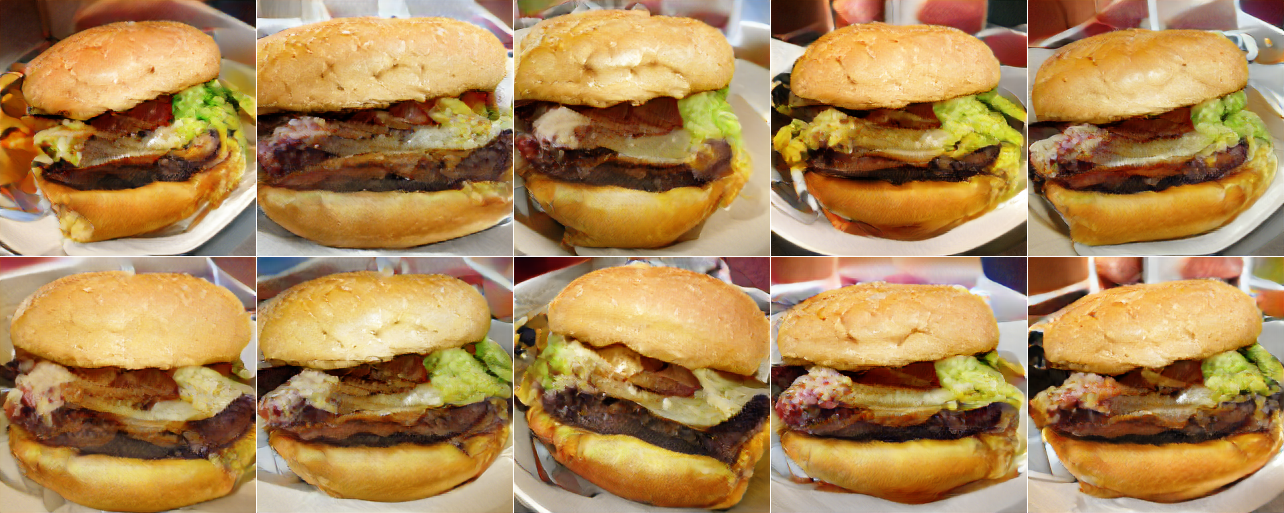

In [5]:
num_samples = 10
truncation = 0.4
noise_seed = 0
category = "933) cheeseburger"

z = truncated_z_sample(num_samples, truncation, noise_seed)
y = int(category.split(')')[0])

ims = sample(sess, z, y, truncation=truncation)
imshow(imgrid(ims, cols=min(num_samples, 5)))

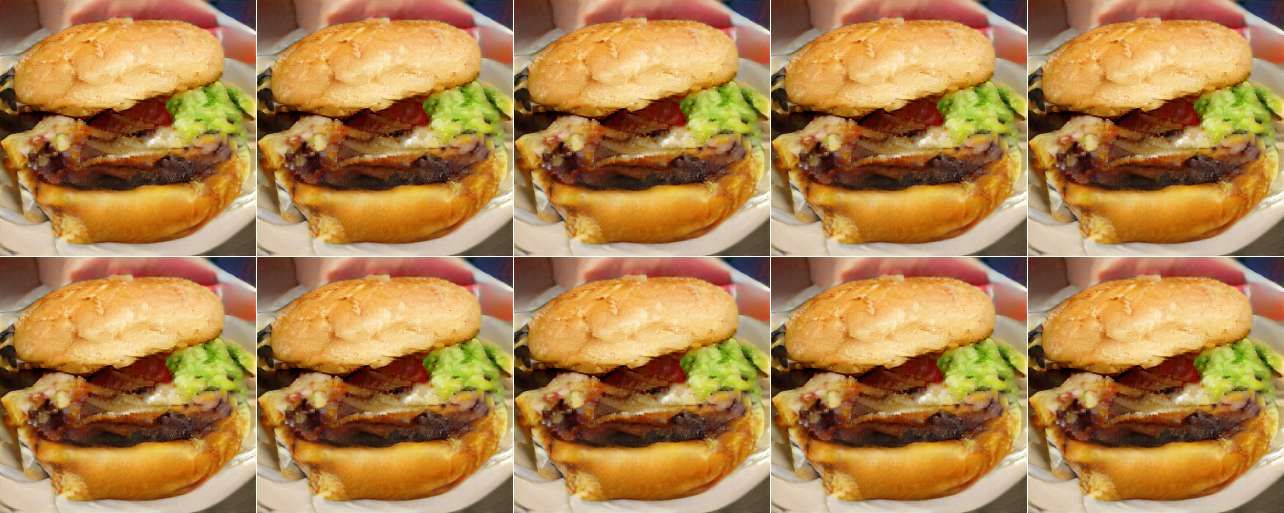

In [15]:
ims = []
images_n = np.random.randint(933, 934, 10)
for i in images_n:
    z = truncated_z_sample(1, truncation, noise_seed)
    ims.append(sample(sess, z, i, truncation=truncation))

imshow(imgrid(np.concatenate(ims, axis=0), cols=5))

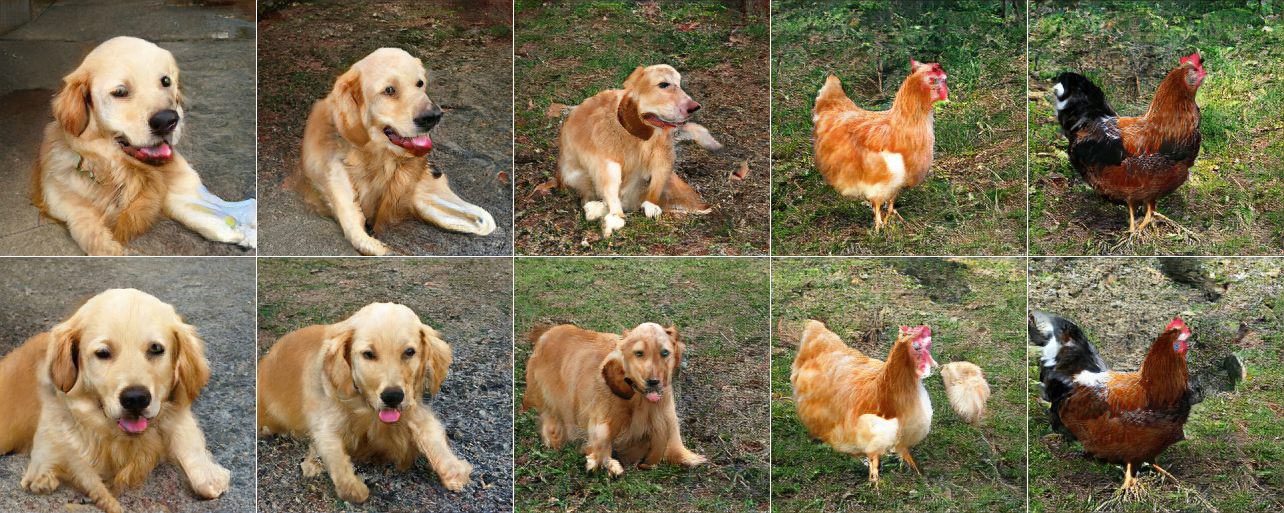

In [6]:
num_samples = 2
num_interps = 5
truncation = 0.2
noise_seed_A = 0
category_A = "207) golden retriever"
noise_seed_B = 0
category_B = "8) hen"

def interpolate_and_shape(A, B, num_interps):
  interps = interpolate(A, B, num_interps)
  return (interps.transpose(1, 0, *range(2, len(interps.shape)))
                 .reshape(num_samples * num_interps, *interps.shape[2:]))

z_A, z_B = [truncated_z_sample(num_samples, truncation, noise_seed)
            for noise_seed in [noise_seed_A, noise_seed_B]]
y_A, y_B = [one_hot([int(category.split(')')[0])] * num_samples)
            for category in [category_A, category_B]]

z_interp = interpolate_and_shape(z_A, z_B, num_interps)
y_interp = interpolate_and_shape(y_A, y_B, num_interps)

ims = sample(sess, z_interp, y_interp, truncation=truncation)
imshow(imgrid(ims, cols=num_interps))